In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Part I : Goal, purpose, target (variable)and initial hypothesis
#### Goal - Reduce churn.
#### Purpose - Prevent revenue lost due to customers leaving (who are then typically harder/costlier to get back).  Could also indicate service delivery issues we aren't aware of.
#### Target - Churn
#### Constraints - Cannot remove month-to-month service plan
#### Initial hypotheses:

- Churn is having a negative effect on revenue (seems obvious but needs to be qualified and quantified).
- Having to pay by check each month makes customers more prone to churn (extra work)
- Having multiple services makes customers less likely to churn
- Type of internet services may have an impact (one may be slower or costlier)
- Larger familes (i.e. dependants & partners) may impact churn - could adjust business plans to accomodate
- Number of phone lines may impact churn - more phone lines are probably lower churn.

### The plan:

#### High level data analysis
1. Determine if the target variable (churn) is happening, and if so, how much?  (i.e., Is there a problem?)
2. What is the magnitude of churn's effect on overall revenue? (How big is the problem?)
#### Deeper modeling and hypothesis testing
3. What other variables are correlated with this varible?  Is it causation?  How do they change through time (i.e. examine both bulk/aggregate and temporal realtionships between variables and churn.  (Why did this happen?)
4. What would the positive impact on revenue by removing the impact of certain variables?  What is my recommendation to get there?  Anything else I would want to know?

## Part II: High Level Data Analysis

In [108]:
df = pd.read_csv('storytelling_project_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_id                7049 non-null   object 
 1   gender                     7049 non-null   object 
 2   is_senior_bool             7049 non-null   int64  
 3   is_senior                  7049 non-null   object 
 4   payment_type               7049 non-null   object 
 5   monthly_charges            7049 non-null   float64
 6   total_charges              7038 non-null   float64
 7   churn                      7049 non-null   object 
 8   tenure                     7049 non-null   float64
 9   is_female_bool             7049 non-null   int64  
 10  has_churned_bool           7049 non-null   int64  
 11  has_phone_bool             7049 non-null   int64  
 12  has_internet_bool          7049 non-null   int64  
 13  contract_details           7049 non-null   objec

#### General Description

In [142]:
df.head(5).T

,0,1,2,3,4
customer_id,0002-ORFBO,0003-MKNFE,0004-TLHLJ,0011-IGKFF,0013-EXCHZ
gender,Female,Male,Male,Male,Female
is_senior_bool,0,0,0,1,1
is_senior,Non-Senior Citizen,Non-Senior Citizen,Non-Senior Citizen,Senior Citizen,Senior Citizen
payment_type,Mailed check,Mailed check,Electronic check,Electronic check,Mailed check
monthly_charges,65.6,59.9,73.9,98.0,83.9
total_charges,593.3,542.4,280.85,1237.85,267.4
churn,No,No,Yes,Yes,Yes
tenure,9.0,9.1,3.8,12.6,3.2
is_female_bool,1,0,0,0,1


### Question 1 - Is Churn happening?  What is its relative magnitude?

<AxesSubplot:>

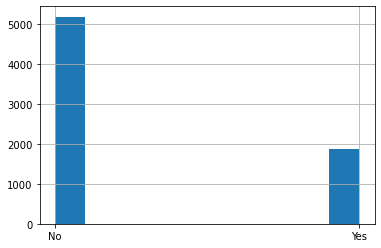

In [131]:
df.churn.hist()

In [136]:
tenure_series = df.groupby('full_months_tenure').has_churned_bool.mean()
tenure_series

full_months_tenure
0     0.000000
1     0.602685
2     0.473430
3     0.483871
4     0.475904
        ...   
74    0.040000
75    0.000000
76    0.000000
77    0.000000
79    0.000000
Name: has_churned_bool, Length: 79, dtype: float64

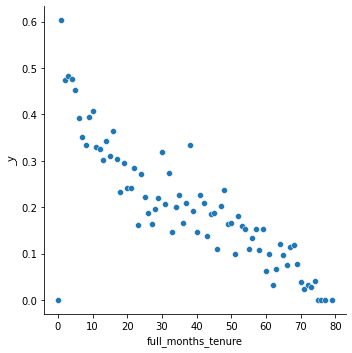

In [148]:
sns.relplot(data = tenure_series, x = tenure_series.index, y = tenure_series.values)

In [111]:
lost = df[df.churn == "Yes"]
kept = df[df.churn == "No"]

In [133]:
# what is the percent of overall churn
lost.shape[0] / df.shape[0]

0.2652858561498085

#### 26.5% of their customers have churned

However, this number indicates overall churn, but not necessarily monthly churn, especailly if the churn was frontloaded (which we will investigate shortly).  **Using a 12 month running average of churn, the average monthly churn is 17.6%**.  Which while better is still much higher than the industry standard goal of 21% per year, or -

In [145]:
.21/12

0.017499999999999998

1.75% per month.

#### Thus, churn is an issue for this company.

### Question 2 - What is the impact of the churn on revenue (aka magnitude of the problem)?

To do this, I will take the difference between the average tenure of when a customer churns, and compare it to the average tneure of am active customer.  That will give me the impact in lost months of revenue per churned customer.  To get the fianncial impact, we multiple these collectiv lost months by the average monthly revenue of a customer to get a ballpack estimate of the loss.

In [132]:
# what is the average tenure of a customer
df.tenure.mean()

32.37980656446458

In [64]:
# how quickly do folks churn, on average, in months
churn_tenure = lost.tenure.mean()
churn_tenure

17.96108563533476

In [65]:
# how does the tenure of non-churning customers compare
non_churn_tenure = kept.tenure.mean()
non_churn_tenure

37.586025552198315

#### Customers churn, on average, in 18 months, while non-churners are around 38 months of service

In [66]:
# Cost of the loss of these customers
loss_per_churn = (non_churn_tenure - churn_tenure) * df.monthly_charges.mean()
loss_per_churn

1270.6562548523746

#### They are losing $1270 for each customer churning.

In [67]:
total_churn_loss = loss_per_churn * lost.shape[0]
total_churn_loss

2376127.1965739406

#### They lost almost $2.4M in revenue due to churn.

## Part III: Deeper Modeling and Hypothesis Testing

#### Question 3 - What is causing the churn?

Note: While I discuss a number of hypothesis above, and investigated most, I will cut to the chase and talk about how I got to the most impactful variables.

First, are churning customers paying more than non-churning customers?

<AxesSubplot:xlabel='churn', ylabel='monthly_charges'>

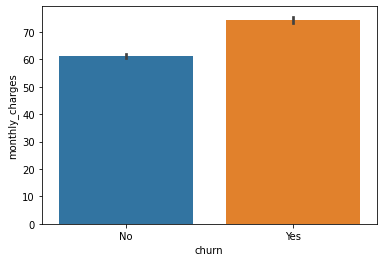

In [40]:
lost.monthly_charges.mean(), kept.monthly_charges.mean()
sns.barplot(x = 'churn', y = 'monthly_charges', data = df)

#### Churned customers are paying about 13 dollars more per month - lets see what that means in services

<AxesSubplot:title={'center':'Current Customers'}>

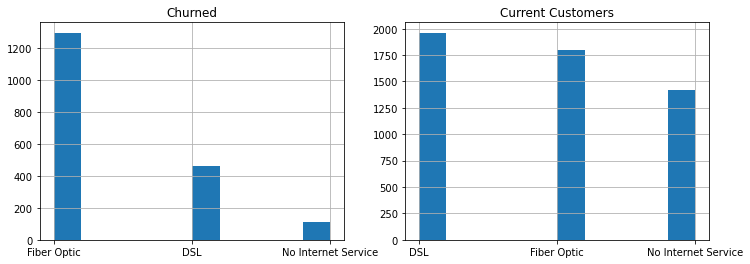

In [69]:
# After doing some pivot tables I noticed most churn is coming from combo customers (hence higher average cost) specifically those using fiber
plt.figure(figsize = (12,4))

plt.subplot(1,2,1, title = "Churned")
lost.internet_service_details.hist()

plt.subplot(1,2,2, title = "Current Customers")
kept.internet_service_details.hist()

In [149]:
df.groupby('churn').payment_type.value_counts()

churn  payment_type             
No     Mailed check                 1304
       Electronic check             1294
       Credit card (automatic)      1292
       Bank transfer (automatic)    1289
Yes    Electronic check             1071
       Mailed check                  308
       Bank transfer (automatic)     259
       Credit card (automatic)       232
Name: payment_type, dtype: int64

Having Fiber Optic serice and paying by electronic check seems to be the biggest driver of churn - almost half of those who use this method are churning, majority of churns are this method.

Interestingly enough, using Tableau and comparing the average monthly cost between the different services and payment methods, the churned customers are not paying more.

Using Tableau, I was able to compare a number of variables against churn, both temporally and in bulk, to see which had the greatest effect on increasing churn.

From a temporal perspective, most churn happens in the first months of service.

From a bulk perspective, most churn is for Fiber customers who pay with electronic check.  The varaibles all seem to move with the same temporal trend as well, meaning they are highly independant.

For some additional analysis of short-term churners:

In [152]:
sample1 = df[['churn','internet_service_details','payment_type']]

In [153]:
short_churned = df[(df.full_months_tenure<=1) & (df.churn == "Yes")]

In [154]:
short_churned.service_combination.value_counts()

Phone & Internet    335
Phone Only           64
Internet Only        50
Name: service_combination, dtype: int64

In [155]:
short_stayed = df[(df.full_months_tenure<=1) & (df.churn == "No")]
short_stayed.service_combination.value_counts()

Phone & Internet    146
Phone Only          135
Internet Only        26
Name: service_combination, dtype: int64

In [156]:
335/(335+146), 64/(64+135), 50/(50+26)

(0.6964656964656964, 0.32160804020100503, 0.6578947368421053)

Thus 70% of Phone and Internet, 32% of Phone only, and 66% Internet only churned in the first month.

In [157]:
short_churned.internet_service_details.value_counts()

Fiber Optic            240
DSL                    145
No Internet Service     64
Name: internet_service_details, dtype: int64

In [158]:
short_stayed.internet_service_details.value_counts()

No Internet Service    135
DSL                    119
Fiber Optic             53
Name: internet_service_details, dtype: int64

In [159]:
240/(240+53), 145/(145+119), 64/(64+135)

(0.8191126279863481, 0.5492424242424242, 0.32160804020100503)

Drilling deeper into the internet serice details, even more dramatic is the first month Fiber optic customers where 82% are churning!  55% of DSL (also very high) and 32% with no internet service.

#### Most people who churn within one month are internet users, specifically those with fiber.

<AxesSubplot:xlabel='churn', ylabel='full_months_tenure'>

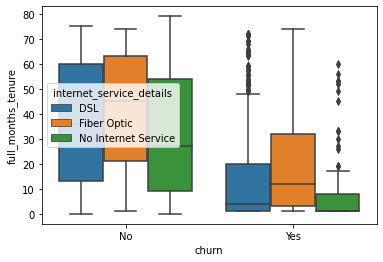

In [160]:
sns.boxplot(x = "churn", y = "full_months_tenure", hue = "internet_service_details", data = df)

### Question 4 - What would the effect on revenue of eliminating the additional churn caused by the main drivers, and what recommendations would you make?

Using Tableau, I removed fiber optic and electronic check customers from the dataset.  This gave me a overall churn of 12.4%, and if we took a proportional month to month guess (17.6%/26.5% ~ x/12.4%) x, which is the approximate month to month churn, is closer to 8.2%.  

If we can reduce the overall rate of churn to 8.2% per month we would prvent the following lost revenue to churn:

(26.5% - 8.2%)/26.5% = Proportion of revenue saved

Total Revenue Saved = Proportion of revenue saved * Total Churn Loss

In [164]:
proportion_of_revenue_saved = (26.5 - 8.2)/26.5
total_revenue_saved = proportion_of_revenue_saved * total_churn_loss
total_revenue_saved

1640872.7432944572

#### Therefore, if we can reduce the churn driven by 
1. New customers (those lasting less than 2 months)
2. Fiber optic users
3. Those who pay by electronic check
#### we can save $1.64M in revenue.

#### Considerations (from discoveries while analyzing the dataset):
- Fiber optic is only used for Phone + Internet customers, although DSL may also be an alernative for these customers (although not sure if there are geographical or other limits).  In these situations, fiber costs, on average, (91.50-64.41) = 27.09 dollars more than DSL.  A potential cause of higher churn among Fiber is that the additional cost is not worth the additional performace over DSL.
- Average monthly charges for electornic check customers are around 10 dollers  higher than credit card and bank transfer payees, and more than 30 dollars higher than mailed check.  This is because most Fiber customers are paying with electornic check, which seems to be compounding the issues Fiber already has (as electornic checks also dominate churn in other services, such as Internet Only (DSL).  I wouldn't be suprised if there was some kind of program put in place to get Fiber users to pay with electronic check, hence the high proportion of customes who pay that way.

#### Recommendations:
1. Offer a first 3 month deal of reduced rates to incentivize new customers to keep sticking around
2. Where possible use DSL and not fiber optic cable.
3. Eliminate or dis-incentivize electronic check usage and shift to other forms of payment - offer better terms for credit card users, as they are the lowest churn payment method.